# Train a Random Forest Regressor Model for multiple outputs
### Outputs include number of color source production as well as the number of lands in that deck

In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit as sss

from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

import seaborn as sns

from joblib import dump, load

In [2]:
pd.options.display.max_columns = 20000
pd.set_option('display.width', 1000)

Get the input and output file paths

In [3]:
# Get the absolute path of the current working directory
current_dir = os.path.abspath(os.getcwd())

# Get the absolute path of the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))

In [4]:
# Read in the input and output feather files
fp_input = os.path.join(parent_dir, 'data', 'input.feather')
fp_output = os.path.join(parent_dir, 'data', 'output.feather')

In [5]:
# Load the dataset using pandas
input = pd.read_feather(fp_input)
output = pd.read_feather(fp_output)

Stratify the input data based on the `avg_cmc` column to ensure a consistent distribution of test and train sets
This will help to reduce sampling bias

In [7]:
# Remove outliers where number of lands is less than 10 or greater than 35
outlier_indexes = output[(output['number_of_lands'] < 10) | (output['number_of_lands'] > 35)].index
# Use the drop method to remove the indexes from the DataFrame
output_no_outlier = output.drop(index=outlier_indexes)
input_no_outlier = input.drop(index=outlier_indexes)

In [19]:
output

,color_sources_W,color_sources_U,color_sources_B,color_sources_R,color_sources_G,color_sources_C,number_of_lands
0,17,18,0,16,0,0,33
1,0,0,24,16,0,0,25
2,0,0,19,15,14,0,24
3,23,2,2,2,18,6,24
4,0,5,15,0,18,2,21
...,...,...,...,...,...,...,...
9294,0,7,3,3,0,2,16
9295,0,5,5,1,0,0,13
9296,0,8,3,0,0,1,16
9297,0,6,4,0,0,4,17


In [21]:
output_no_outlier['land_cat'] = pd.qcut(output_no_outlier['number_of_lands'], q=5, labels=False)
output_no_outlier.groupby('land_cat')['number_of_lands'].agg(['min', 'max', 'count'])

,min,max,count
land_cat,,,
0,10,18,1911
1,19,20,1558
2,21,23,2051
3,24,25,1271
4,26,35,1261


In [9]:
input_no_outlier.shape

(8052, 21)

In [22]:
# Stratify the input data to preserve the cmc distribution in training and testing set
split = sss(n_splits=1, test_size=0.2, random_state=69)

for train_index, test_index in split.split(output_no_outlier, output_no_outlier['land_cat']):
    X_train = input_no_outlier.iloc[train_index]
    X_test = input_no_outlier.iloc[test_index]
    y_train = output_no_outlier.iloc[train_index]
    y_test = output_no_outlier.iloc[test_index]

In [40]:
for set in (input_no_outlier, output_no_outlier):
    try:
        set.drop(['land_cat'], axis=1, inplace=True)
    except:
        continue

array([[<Axes: title={'center': 'avg_cmc'}>,
        <Axes: title={'center': 'cast_cost_W'}>,
        <Axes: title={'center': 'cast_cost_U'}>,
        <Axes: title={'center': 'cast_cost_B'}>],
       [<Axes: title={'center': 'cast_cost_R'}>,
        <Axes: title={'center': 'cast_cost_G'}>,
        <Axes: title={'center': 'cast_cost_C'}>,
        <Axes: title={'center': 'cast_cost_P'}>],
       [<Axes: title={'center': 'produces_W'}>,
        <Axes: title={'center': 'produces_U'}>,
        <Axes: title={'center': 'produces_B'}>,
        <Axes: title={'center': 'produces_R'}>],
       [<Axes: title={'center': 'produces_G'}>,
        <Axes: title={'center': 'produces_C'}>,
        <Axes: title={'center': 'num_x_in_mana_cost'}>,
        <Axes: title={'center': 'has_looting'}>],
       [<Axes: title={'center': 'has_carddraw'}>,
        <Axes: title={'center': 'makes_treasure_tokens'}>,
        <Axes: title={'center': 'reduced_spells'}>,
        <Axes: title={'center': 'free_spells'}>]], dty

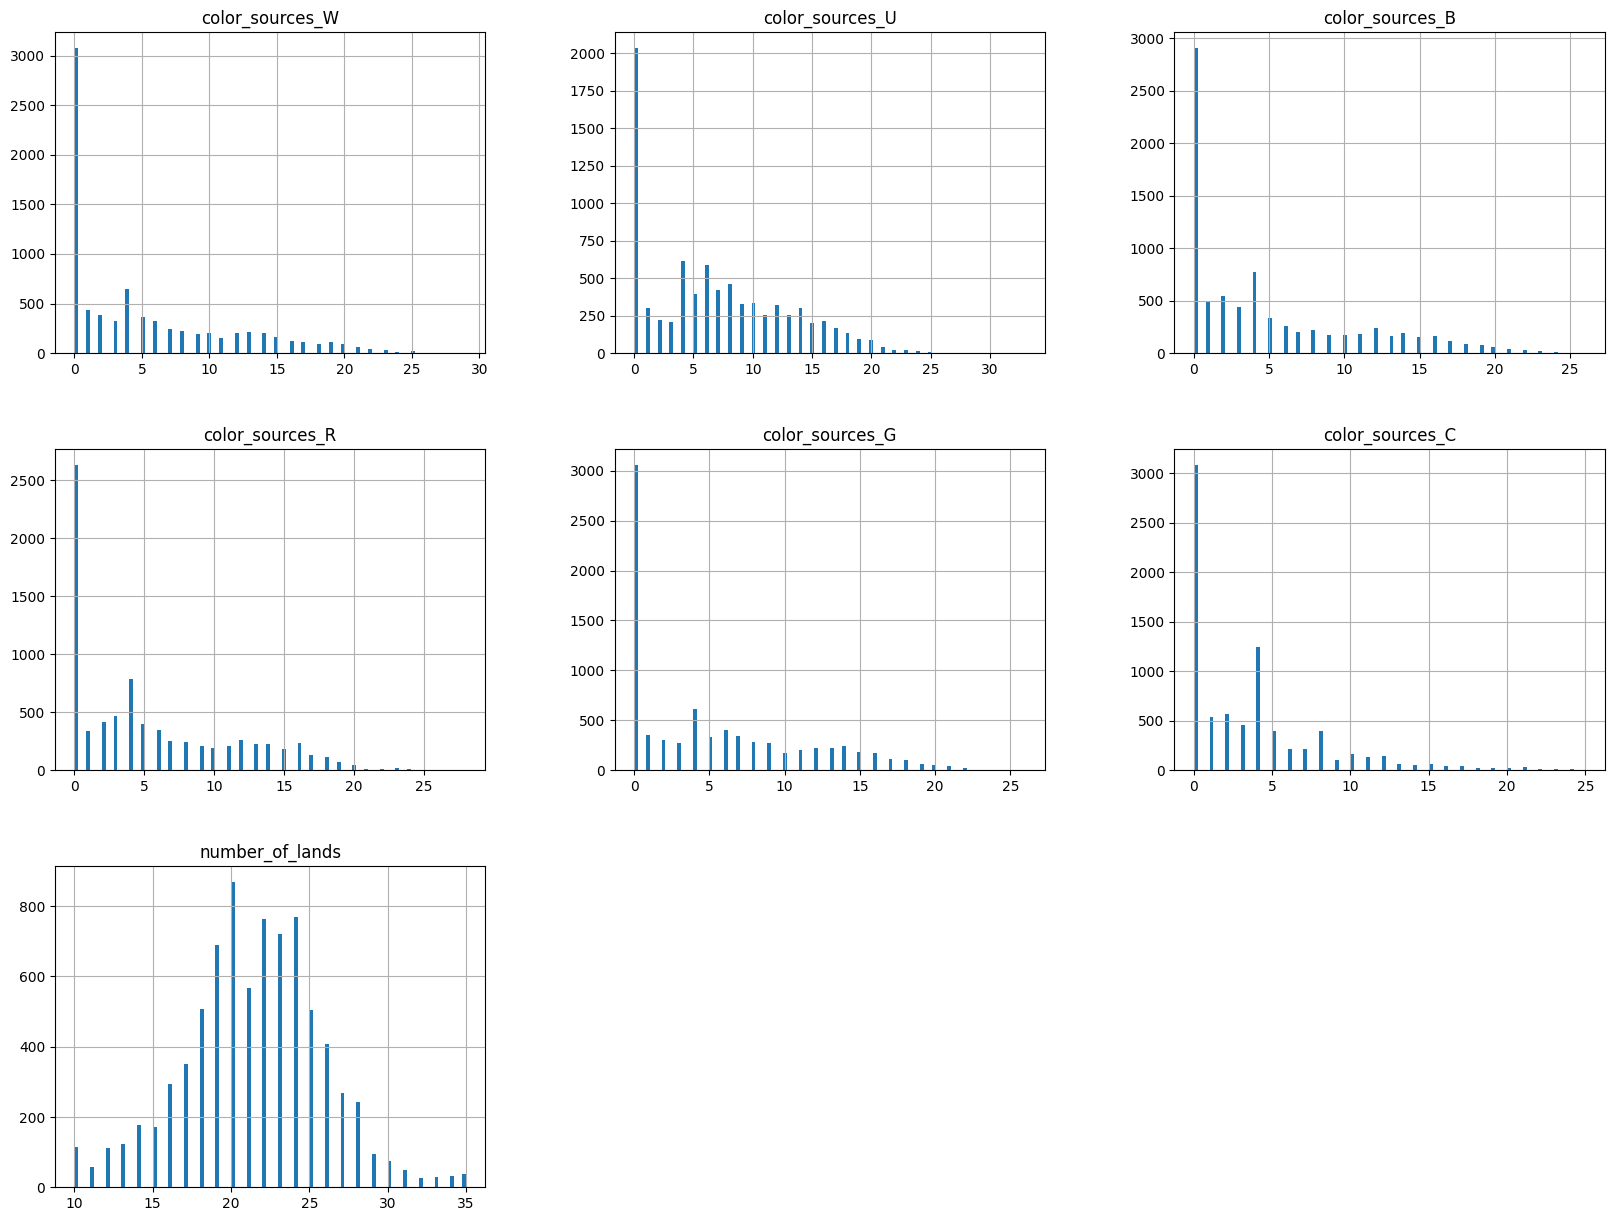

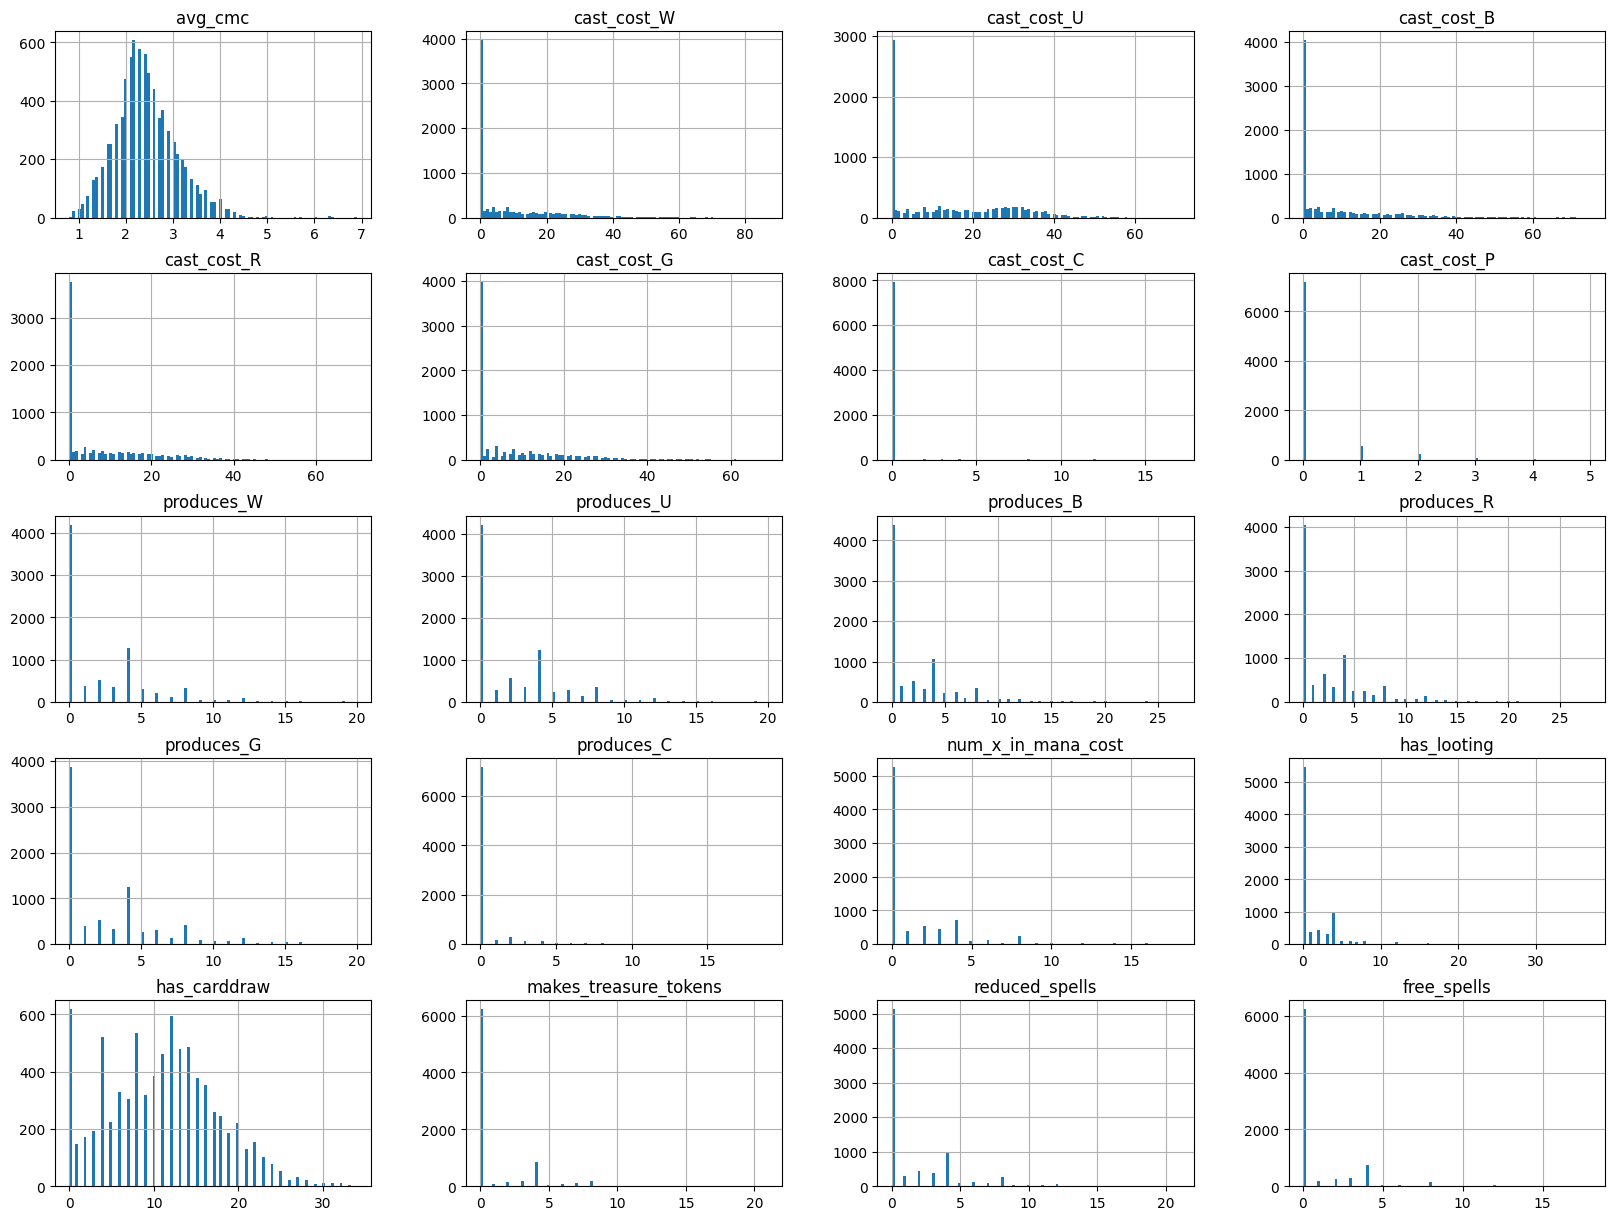

In [44]:
output_no_outlier.hist(bins=100, figsize=(20,15))
input_no_outlier.hist(bins=100, figsize=(20,15))

We can view the relationships between all of the features

In [13]:
# # Combine the input and output data into a single dataframe
# data = pd.concat([input, output], axis=1)

# # Plot the pairwise scatterplots
# sns.pairplot(data)

Perform Grid-search to find the optimal hyperparameter values

In [ ]:
# Define the hyperparameters grid to search
param_grid = {
    'estimator__n_estimators': [10, 50, 100, 200],
    'estimator__max_depth': [None, 10, 20, 30],
    'estimator__min_samples_split': [2, 5, 10, 15],
    'estimator__min_samples_leaf': [1, 2, 5, 10]
}

# Instantiate the RandomForestRegressor
rf_gridsearch = RandomForestRegressor(random_state=42)

# Wrap the RandomForestRegressor with MultiOutputRegressor
multi_output_rf = MultiOutputRegressor(rf_gridsearch)

# Instantiate the GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=multi_output_rf, param_grid=param_grid,
                           cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Fit the GridSearchCV on the training data
grid_search.fit(X_train, y_train)

In [50]:
best_params = grid_search.best_params_
print("Best hyperparameters found by grid search:")
print(best_params)

best_model = grid_search.best_estimator_

# Make predictions using the best model
y_pred = best_model.predict(X_test)
# column_names = y_test.columns
# # convert from np.array to pd.dataframe
# y_pred = pd.DataFrame(y_pred, columns=column_names)

# Calculate the root mean squared error
rmse_per_target = mean_squared_error(y_test, y_pred, multioutput='raw_values') ** 1/2
print("Root Mean Squared Error for each target variable:", rmse_per_target)

# Calculate the R-squared score
r2_scores_per_target = r2_score(y_test, y_pred, multioutput='raw_values')
print("R-squared scores for each target variable:", r2_scores_per_target)

# Calculate the mean absolute error
mae_per_target = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
print("Mean Absolute Error for each target variable:", mae_per_target)

Best hyperparameters found by grid search:
{'estimator__max_depth': 30, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 200}
Root Mean Squared Error for each target variable: [0.48492621 0.74771996 0.54171881 0.554781   0.49169128 0.44382476
 0.66137285]
R-squared scores for each target variable: [0.97390253 0.96117942 0.96820363 0.96689311 0.96985643 0.95724654
 0.93143506]
Mean Absolute Error for each target variable: [0.49373926 0.6218469  0.54430277 0.52406691 0.50104247 0.52714378
 0.58520597]


A well-fitted residual plot should display a stochastic pattern, meaning that the residuals are randomly distributed around the horizontal line at zero without any discernible trends, indicating that the model has adequately captured the underlying structure of the data.

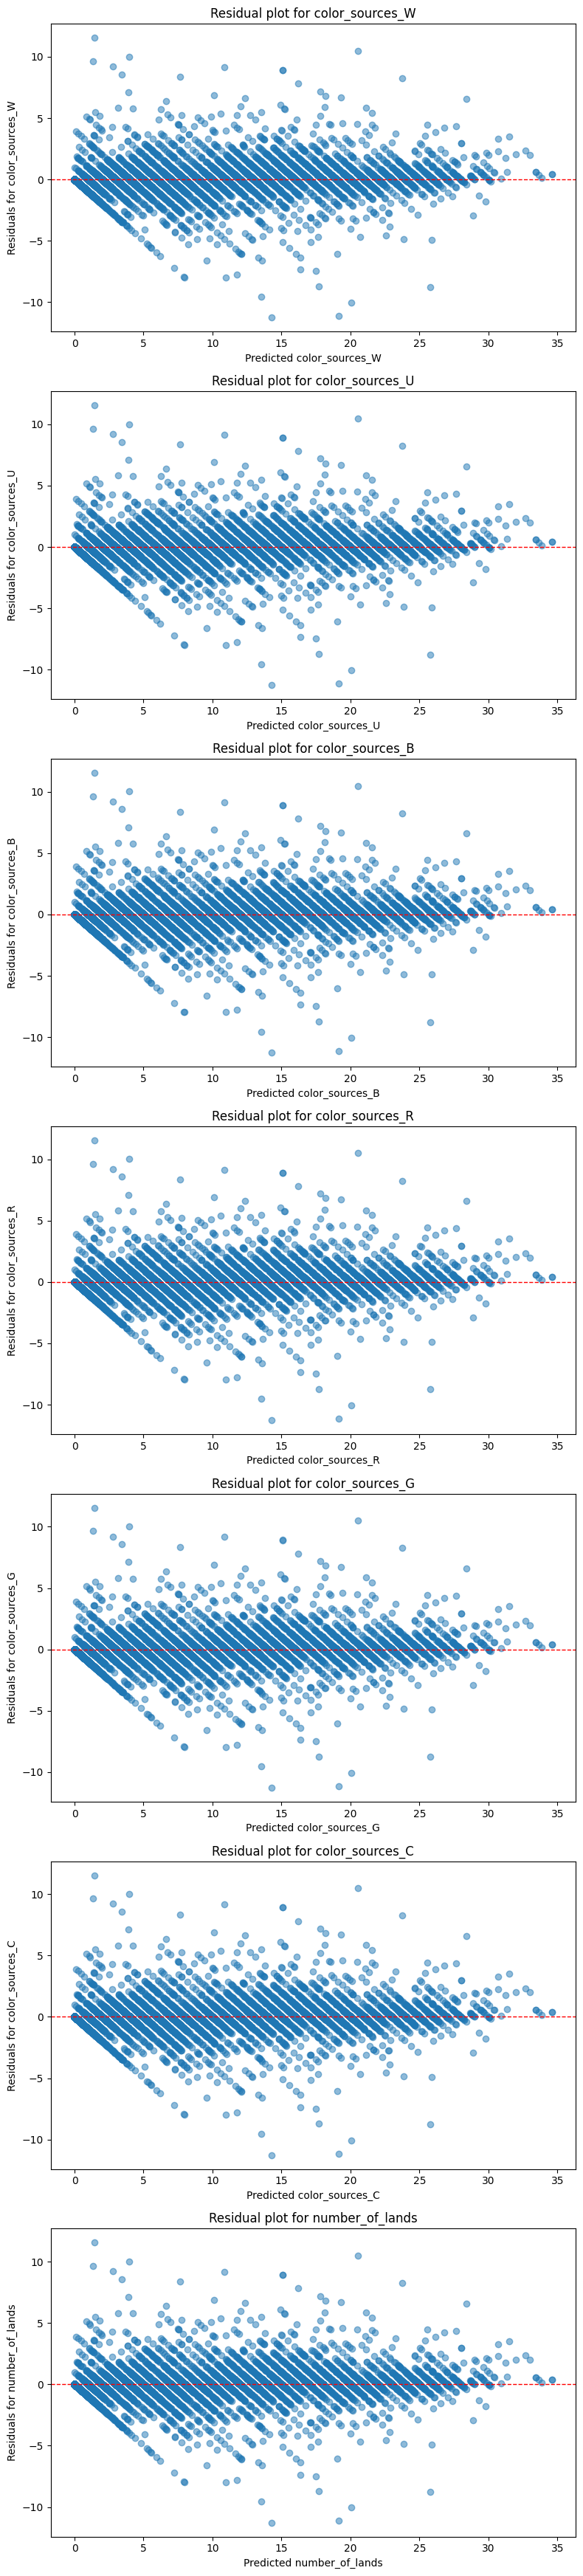

In [55]:
n_targets = y_test.shape[1]

# Set up the figure and axes for subplots
fig, axes = plt.subplots(nrows=n_targets, ncols=1, figsize=(8, 5 * n_targets))

residuals = y_test - y_pred

# Loop through target variables and create residual plots
for i in range(n_targets):
    target_name = y_test.columns[i]
    axes[i].scatter(y_pred, residuals, alpha=0.5)
    axes[i].axhline(y=0, color='r', linestyle='--', linewidth=1)
    axes[i].set_xlabel(f'Predicted {target_name}')
    axes[i].set_ylabel(f'Residuals for {target_name}')
    axes[i].set_title(f'Residual plot for {target_name}')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()


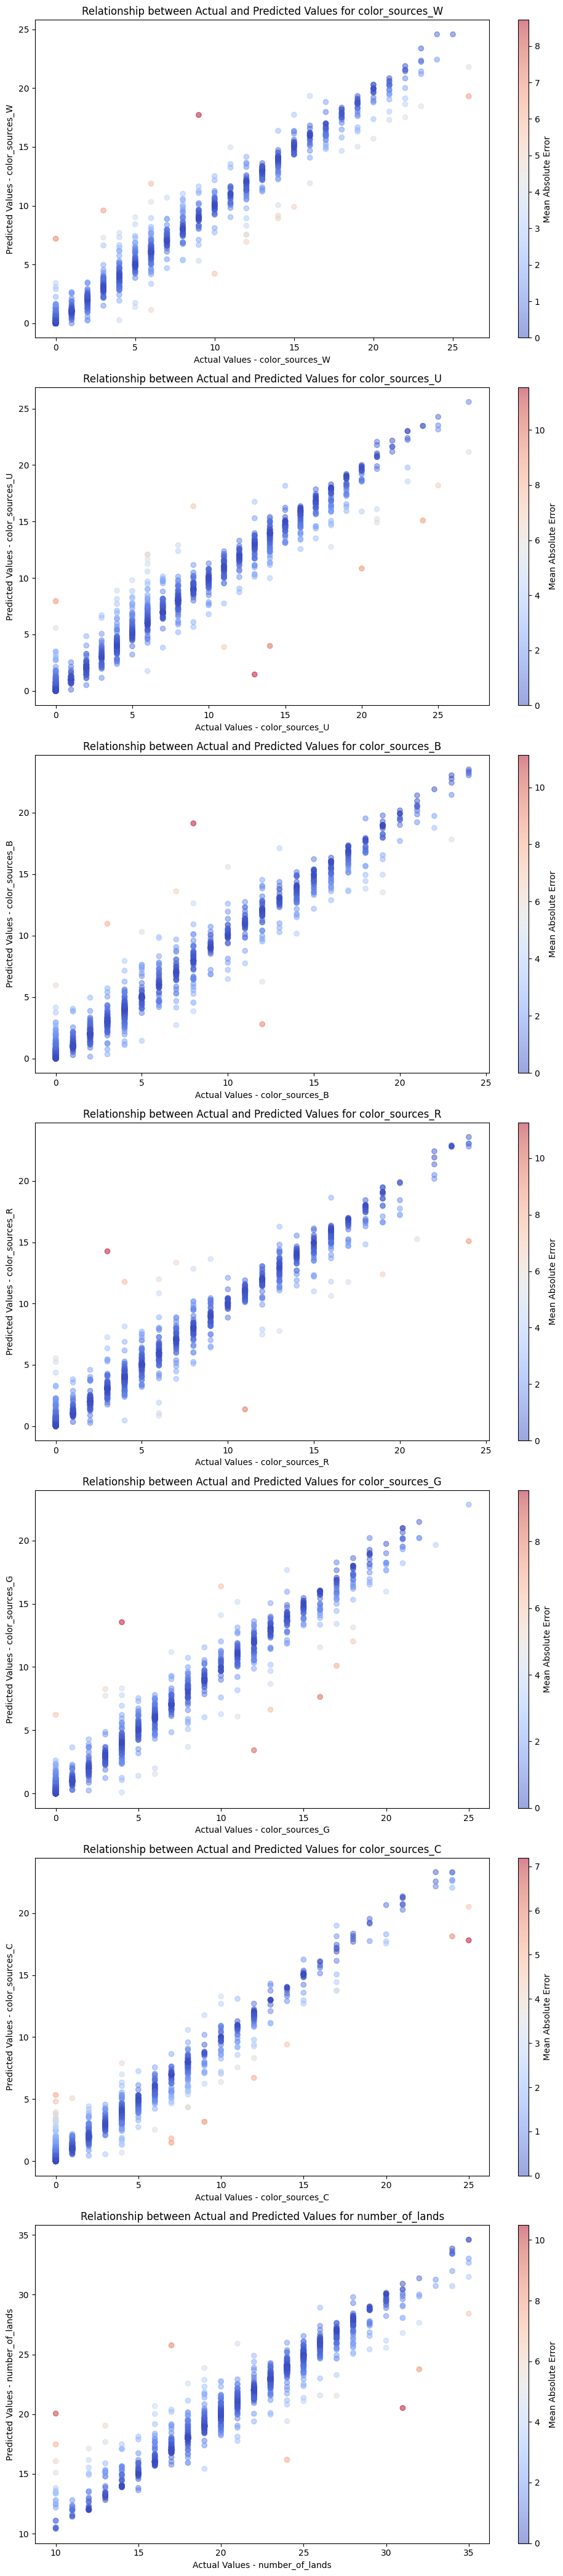

In [47]:
# Calculate the mean absolute errors for each prediction
mae_errors = np.abs(y_test - y_pred)

# Plot the scatter plot for each dimension
n_dimensions = mae_errors.shape[1]
fig, axes = plt.subplots(n_dimensions, 1, figsize=(10, 6 * n_dimensions))

# # Convert y_test from a numpy array to a pandas DataFrame
# y_test_pred = pd.DataFrame(y_test, columns=output.columns)

for i in range(n_dimensions):
    output_feature_name = y_test.columns[i]
    sm = axes[i].scatter(y_test.iloc[:, i], y_pred[:, i], c=mae_errors.iloc[:, i], cmap='coolwarm', alpha=0.5)
    axes[i].set_xlabel(f'Actual Values - {output_feature_name}')
    axes[i].set_ylabel(f'Predicted Values - {output_feature_name}')
    axes[i].set_title(f'Relationship between Actual and Predicted Values for {output_feature_name}')
    plt.colorbar(sm, ax=axes[i], label='Mean Absolute Error', aspect=30)

plt.tight_layout()
plt.show()

In [49]:
# Save the compressed model to disk
dump(best_model, 'C:/Users/Peter/Documents/GitHub/MTG-Land-Recommender/rf_multioutput_linear_no-outliers.joblib.z', compress=True)

['C:/Users/Peter/Documents/GitHub/MTG-Land-Recommender/rf_multioutput_linear_no-outliers.joblib.z']